In [ ]:
import numpy as np
np.random.seed(4)
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader.data as web
import datetime

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dense, LSTM
from keras.models import Sequential

In [ ]:
#
# Funciones auxiliares
#
def graficar_predicciones(real, prediccion):
    plt.plot(real[0:len(prediccion)],color='red', label='Valor real de la acción')
    plt.plot(prediccion, color='blue', label='Predicción de la acción')
    plt.ylim(1.1 * np.min(prediccion)/2, 1.1 * np.max(prediccion))
    plt.xlabel('Tiempo')
    plt.ylabel('Valor de la acción')
    plt.legend()
    plt.show()

In [ ]:
#
# Lectura de los datos
#
#dataset = pd.read_csv('Futuros del Índice S&P 500 - Este es el bueno.csv', index_col='Fecha', parse_dates=['Fecha'])
#dataset.head()
start = datetime.datetime(2015,1,1)
end = datetime.datetime(2020,12,31)
dataset = web.get_data_yahoo('VOO','01/01/2010',interval='m')
dataset.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-10-01,109.279999,103.500000,105.080002,108.300003,951600.0,88.645699
2010-11-01,112.300003,107.480003,108.919998,108.180000,1070400.0,88.547455
2010-12-01,115.599998,109.879997,109.919998,115.139999,1670300.0,94.244339
2011-01-01,119.220001,115.480003,115.940002,117.699997,4402150.0,96.780792
2011-02-01,123.220001,118.379997,118.480003,121.779999,2761400.0,100.135674


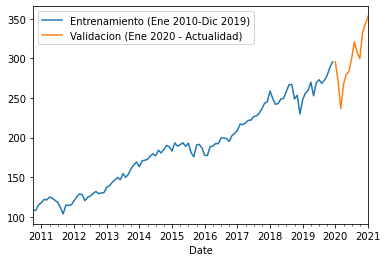

In [ ]:
#
# Sets de entrenamiento y validación 
# La LSTM se entrenará con datos de 2016 hacia atrás. La validación se hará con datos de 2017 en adelante.
# En ambos casos sólo se usará el valor más alto de la acción para cada día
#

set_entrenamiento = dataset['2010':'2019'].iloc[:,3:4]
set_validacion = dataset['2020':].iloc[:,3:4]
set_entrenamiento['Close'].plot(legend=True)
set_validacion['Close'].plot(legend=True)
plt.legend(['Entrenamiento (Ene 2010-Dic 2019)', 'Validacion (Ene 2020 - Actualidad)'])
plt.show()

In [ ]:
# Normalización del set de entrenamiento
sc = MinMaxScaler(feature_range=(0,1))
print(sc)
print(set_entrenamiento)
set_entrenamiento_escalado = sc.fit_transform(set_entrenamiento)

MinMaxScaler(copy=True, feature_range=(0, 1))
                 Close
Date                  
2010-10-01  108.300003
2010-11-01  108.180000
2010-12-01  115.139999
2011-01-01  117.699997
2011-02-01  121.779999
...                ...
2019-08-01  268.600006
2019-09-01  272.600006
2019-10-01  278.549988
2019-11-01  288.649994
2019-12-01  295.799988

[111 rows x 1 columns]


## La red LSTM tendrá como entrada "time_step" datos consecutivos, y como salida 1 dato (la predicción a
# partir de esos "time_step" datos). Se conformará de esta forma el set de entrenamiento
time_step = 726
X_train = []
Y_train = []
m = len(set_entrenamiento_escalado)

In [ ]:
time_step = 3
X_train = [] 
Y_train = [] 
m = len(set_entrenamiento_escalado)

In [ ]:
for i in range(time_step,m):
    # X: bloques de "time_step" datos: 0-time_step, 1-time_step+1, 2-time_step+2, etc
    X_train.append(set_entrenamiento_escalado[i-time_step:i,0])
    # Y: el siguiente dato
    Y_train.append(set_entrenamiento_escalado[i,0])
X_train, Y_train = np.array(X_train), np.array(Y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
len(X_train)

108

In [ ]:
#
# Red LSTM
#
dim_entrada = (X_train.shape[1],1)
dim_salida = 1
print(dim_entrada)
na = 120

modelo = Sequential()
modelo.add(LSTM(units=na, input_shape=dim_entrada))
modelo.add(Dense(units=dim_salida))
modelo.compile(optimizer='rmsprop', loss='mse')
modelo.fit(X_train,Y_train,epochs=20,batch_size=12)

(3, 1)
Epoch 1/20
9/9 [==============================] - 2s 4ms/step - loss: 0.1329
Epoch 2/20
9/9 [==============================] - 0s 3ms/step - loss: 0.0121
Epoch 3/20
9/9 [==============================] - 0s 3ms/step - loss: 0.0074
Epoch 4/20
9/9 [==============================] - 0s 3ms/step - loss: 0.0046
Epoch 5/20
9/9 [==============================] - 0s 3ms/step - loss: 0.0031
Epoch 6/20
9/9 [==============================] - 0s 3ms/step - loss: 0.0023
Epoch 7/20
9/9 [==============================] - 0s 3ms/step - loss: 0.0031
Epoch 8/20
9/9 [==============================] - 0s 3ms/step - loss: 0.0016
Epoch 9/20
9/9 [==============================] - 0s 4ms/step - loss: 0.0017
Epoch 10/20
9/9 [==============================] - 0s 4ms/step - loss: 0.0028
Epoch 11/20
9/9 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 12/20
9/9 [==============================] - 0s 4ms/step - loss: 0.0023
Epoch 13/20
9/9 [==============================] - 0s 3ms/step - l

                 Close
Date                  
2020-01-01  295.690002
2020-02-01  271.739990
2020-03-01  236.820007
2020-04-01  267.100006
2020-05-01  279.750000
2020-06-01  283.429993
2020-07-01  300.100006
2020-08-01  321.019989
2020-09-01  307.649994
2020-10-01  299.820007
2020-11-01  332.640015
2020-12-01  343.690002
2021-01-01  351.899994
2021-01-25  353.329987
[[290.95673]
 [271.8555 ]
 [269.269  ]
 [290.40298]
 [302.22116]
 [315.74512]
 [329.87457]
 [333.5522 ]
 [330.9797 ]
 [342.94553]
 [366.939  ]]


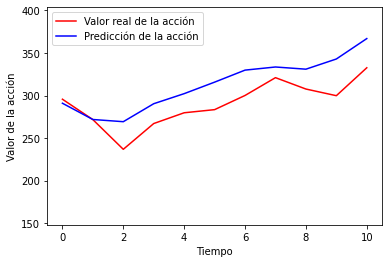

In [ ]:
#
# Validación (predicción del valor de las acciones)
#

x_test = set_validacion.values
x_test = sc.transform(x_test)

X_test = []

m = len(x_test)
for i in range(time_step,m):
  X_test.append(x_test[i-time_step:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

prediccion = modelo.predict(X_test)
prediccion = sc.inverse_transform(prediccion)

# Graficar resultados
print(set_validacion)
print(prediccion)
graficar_predicciones(set_validacion.values,prediccion)